## Introduction

The Netflix Prize was an open competition for the best collaborative filtering algorithm to predict user ratings for films, based on previous ratings without any other information about the users or films. The competition was held by Netflix, an online DVD rental service, and ran from October 2006 to September 2009. The winning team, BellKor's Pragmatic Chaos, received a $1 million prize for their algorithm, which improved the accuracy of Netflix's recommendation system by over 10%.

The winning algorithm is a complex one. It combines over 800 predictive features and uses sophisticated blending techniques. It included elements from multiple teams and used various methods such as matrix factorization, temporal dynamics and ensemble methods.  The algorithm did not get adopted by Netflix production system due to its complexity.   Nonetheless, the essential techniques, such as matrix factorization and ensemble method, are fundamental in recommendation system and we will explore them in this notebook.

## Read and Clean data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
def load_rating_data(fileDir, fileName):
    # load the Netflix data in 
    df = pd.read_csv(fileDir + fileName, header = None, names = ['Cust_Id', 'Rating', 'Date'], usecols=[0, 1, 2])

    # movie ID
    dfM = df[df['Rating'].isna()][['Cust_Id']].copy()
    dfM.rename(columns = {'Cust_Id' : 'Movie_Id'}, inplace=True)

    dfT = pd.merge(left = df, right = dfM, how = 'left', left_index=True, right_index=True)
    dfT['Movie_Id'] = dfT['Movie_Id'].ffill().apply(lambda i: i[:-1])
    dfT = dfT[~dfT['Rating'].isna()]

    dfT[['Cust_Id', 'Movie_Id']] = dfT[['Cust_Id', 'Movie_Id']].astype(int)
    return dfT

def load_probe_data(fileDir, fileName):
    df = pd.read_csv(fileDir + fileName, header = None, names = ['Cust_Id'], usecols=[0])

    isMovie = df['Cust_Id'].str.contains(':')
    dfM = df[isMovie].copy()
    dfM.rename(columns = {'Cust_Id' : 'Movie_Id'}, inplace=True)

    dfT = pd.merge(left = df, right = dfM, how = 'left', left_index=True, right_index=True)
    dfT['Movie_Id'] = dfT['Movie_Id'].ffill().apply(lambda i: i[:-1])
    dfT = dfT[~isMovie]

    dfT[['Cust_Id', 'Movie_Id']] = dfT[['Cust_Id', 'Movie_Id']].astype(int)
    return dfT

In [3]:
# load the rating dataset
df1 = load_rating_data('./netflix-prize-data/', 'combined_data_1.txt')
# df2 = load_rating_data('./netflix-prize-data/', 'combined_data_2.txt')
# df3 = load_rating_data('./netflix-prize-data/', 'combined_data_3.txt')
# df4 = load_rating_data('./netflix-prize-data/', 'combined_data_4.txt')
dfRating = pd.concat([df1])   #[df1, df2, df3, df4]

# laod the probe dataset, which is a subset of rating dataset.  We mark probe dataset as testing data while the rest as training data
dfProbe = load_probe_data('./netflix-prize-data/', 'probe.txt')
dfProbe['test'] = True

dfRating = pd.merge(dfRating, dfProbe, how = 'left', on = ['Cust_Id', 'Movie_Id']).fillna({'test':False}).infer_objects(copy=False)
print(f"the percentage of testing dataset is: {dfRating['test'].sum() / dfRating.shape[0]:.2%}")

# dfTitle = pd.read_csv('./netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'], on_bad_lines='skip')
# dfTitle.head(3)

the percentage of testing dataset is: 2.40%


C:\Users\wuyan\AppData\Local\Temp\ipykernel_2796\2623125676.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfRating = pd.merge(dfRating, dfProbe, how = 'left', on = ['Cust_Id', 'Movie_Id']).fillna({'test':False}).infer_objects(copy=False)


## Basic Stats

In [4]:
movie_count = dfRating['Movie_Id'].nunique()
cust_count = dfRating['Cust_Id'].nunique()
rating_count = len(dfRating['Rating'])
print(f"movie_cout {movie_count:,}, cust_count {cust_count:,} rating_count {rating_count:,}")
print(f"movie-user-matrix size = {movie_count * cust_count:,} number of non-zero entries {rating_count:,}, percentage of non-zero {rating_count / (movie_count * cust_count):.2%}")
print(f"rating mean {dfRating['Rating'].mean():.2f}, rating std {dfRating['Rating'].std():.2f}")

movie_cout 4,499, cust_count 470,758 rating_count 24,053,764
movie-user-matrix size = 2,117,940,242 number of non-zero entries 24,053,764, percentage of non-zero 1.14%
rating mean 3.60, rating std 1.09


## Data Trimming

In [5]:
def randomSelect(dfData, pct):
    import random
    random.seed(42)
    customers = list(dfData['Cust_Id'].unique())
    movies = list(dfData['Movie_Id'].unique())
    random_customers = random.sample(customers, round(len(customers) * pct))
    random_movies = random.sample(movies, round(len(movies) * pct))
    isSelected = dfData['Cust_Id'].isin(random_customers) & dfData['Movie_Id'].isin(random_movies)
    return dfData[isSelected].copy(),dfData[~isSelected].copy() 

In [28]:
# split the data into kept data df and dropped data df1
option = 1

if option == 1: ### 1, no trimming
    df = dfRating.copy()
    df1 = pd.DataFrame()
elif option == 2: ### 2, trim user or movie with little data, the assumption here is that user or movie with little data is with low qaulity and we drop them
    measures = ['count', 'mean']
    targePct = 0.7
    df = dfRating.copy()
    df[['Cust_Id', 'Movie_Id']] = df[['Cust_Id', 'Movie_Id']].astype(int)
    df_movie_summary = df.groupby(['Movie_Id'])['Rating'].agg(measures)
    movie_cutoff = round(df_movie_summary['count'].quantile(targePct), 0)
    movie_to_drop = df_movie_summary[df_movie_summary['count'] < movie_cutoff].index
    print(f"movie_cutoff {movie_cutoff}, percentage of row to drop {len(movie_to_drop) / df_movie_summary.shape[0]:.2%}")
    df_cust_summary = df.groupby(['Cust_Id'])['Rating'].agg(measures)
    cust_cutoff = round(df_cust_summary['count'].quantile(targePct), 0)
    cust_to_drop = df_cust_summary[df_cust_summary['count'] < cust_cutoff].index
    print(f"cust_cutoff {cust_cutoff}, percentage of column to drop {len(cust_to_drop) / df_cust_summary.shape[0]:.2%}")
    df = df[(~df['Movie_Id'].isin(movie_to_drop)) & (~df['Cust_Id'].isin(cust_to_drop))]
    df1 = dfRating[(dfRating['Movie_Id'].isin(movie_to_drop)) | (dfRating['Cust_Id'].isin(cust_to_drop))]
    print(f"Percentage of data keept = {df.shape[0]/dfRating.shape[0]:.2%}")
elif option == 3: ### 3, randomly trim, useful for debugging/developing purpose
    pct1 = 0.1
    df,df1 = randomSelect(dfRating, pct1)
    print(f"number of customers {len(df['Cust_Id'].unique())}, number of movies {len(df['Movie_Id'].unique())}")


# split the data (df, df1) into training and testing based on column of "test"
dfTrain = df[df['test'] == False]
dfTest = df[df['test'] == True]

# df1Train = df1[df1['test'] == False]
# df1Test = df1[df1['test'] == True]

## SVD from suprise

### Convert the dataframe to surprise format

In [20]:
from surprise import Reader, Dataset, SVD, accuracy
def convertDf2SurpriseData(dfTest, dfTrain):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(dfTrain[['Cust_Id', 'Movie_Id', 'Rating']], reader)
    trainset = data.build_full_trainset()
    testset = list(dfTest[['Cust_Id', 'Movie_Id', 'Rating']].itertuples(index=False, name=None))
    return trainset, testset

In [21]:
trainset, testset = convertDf2SurpriseData(dfTest, dfTrain)
trainset1, testset1 = convertDf2SurpriseData(df1Test, df1Train)

### SVD with different model dimension n_factors

In [13]:
### train the SVD model with n_factors = 25, 50, 100, record the training RMSE and testing RMSE
run = False
if ResourceWarning:
    n_factors = [25, 50, 100]
    train_rmse = []
    test_rmse = []

    for n in n_factors:
        algo = SVD(n_factors = n)
        algo.fit(trainset)
        predictions = algo.test(testset)
        train_rmse.append(accuracy.rmse(algo.test(trainset.build_testset())))
        test_rmse.append(accuracy.rmse(predictions))

## output
# n_factor	training rmse	testing rmse
# 25	0.8208	1.0032
# 50	0.7977	1.0047
# 100	0.7664	1.0073
# each takes about 25 mins to run

From the output, testing RMSE is much worse than the training RMSE, indicating there is probability of overfitting, so we need try to tune the regularization parameter

### SVD with different regularization parameter reg_all

In [20]:
### train the SVD model with different regularization parameter, record the testing RMSE
run = False
if run:
    reg_all = [0.001, 0.005, 0.01, 0.02]
    test_rmse = []
    for reg in reg_all:
        print(f"reg_all = {reg}")
        algo = SVD(reg_all = reg)
        algo.fit(trainset)
        predictions = algo.test(testset)
        test_rmse.append(accuracy.rmse(predictions))

## output
# reg_all = 0.001
# RMSE: 1.1043
# reg_all = 0.005
# RMSE: 1.0545
# reg_all = 0.01
# RMSE: 1.0279
# reg_all = 0.02
# RMSE: 1.0066
# reg_all = 0.05
# RMSE: 1.0075

The RMSE is minized when reg_all = 0.02, we will keep using this value.  But the testing RMSE is still very big compare to winning algorithm (~0.85), we still have a lot of room to improve.

### SVD with sparse data trimmed

In [ ]:
### here we have two sets of data, one is kept data, the other is dropped data.  We train the model with both data and compare the testing RMSE
run = True
if run:
    algo = SVD(n_factors = 100, reg_all = 0.02)
    algo.fit(trainset)
    predictions = algo.test(testset)
    print(f"the RMSE for testset is {accuracy.rmse(predictions):.2f}")

    algo1 = SVD(n_factors = 100, reg_all = 0.02)
    algo1.fit(trainset1)
    predictions1 = algo1.test(testset1)
    print(f"the RMSE for testset1 is {accuracy.rmse(predictions1):.2f}")


# output
# RMSE for testset is 0.87
# RMSE for testset1 is 1.06
# 

As we can see here, the performance for kept data (movies and users with enough ratings) is much better than dropped data (movies and users with sparse ratings).  This indicates the collaborative filtering (CF) perform better on movies and users with enough ratings.  Now let's dig into the two data sets to see if we can find anything that leads to this performance difference.  

First, we see the standard deviation of dropped data is 1.14, comparing with 1.06 for the kept data. This means the dropped data is noisier thus harder to predict than kept data.  This agrees with my intuition, i.e. the movies or users with more ratings are easier to predict.

In [ ]:
# plot the distribution of rating for df and df1 with plotly
# import plotly.express as px
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Histogram(x = df['Rating'], name = 'df', histnorm='probability', nbinsx = 5))
# fig.add_trace(go.Histogram(x = df1['Rating'], name = 'df1', histnorm='probability', nbinsx = 5))
# fig.show()

# print(f"df rating mean {df['Rating'].mean():.2f}, rating std {df['Rating'].std():.2f}")
# print(f"df1 rating mean {df1['Rating'].mean():.2f}, rating std {df1['Rating'].std():.2f}")

### SVD++ with default parameters

In [ ]:
# train the SVDpp model with the data and calculate the RMSE for testing dataset
from surprise import SVDpp
algo = SVDpp(n_factors = 100, reg_all = 0.02)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)


# output: takes about 55 mins to run
# RMSE: 1.0201


## XGBoost

In [15]:
from datetime import datetime
import xgboost as xgb

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [16]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

Training the model..


c:\Users\wuyan\Projects\Anaconda\envs\surprise-env\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done. Time taken : 0:01:07.886653

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1138858509940275
MAPE :  35.58440577406212


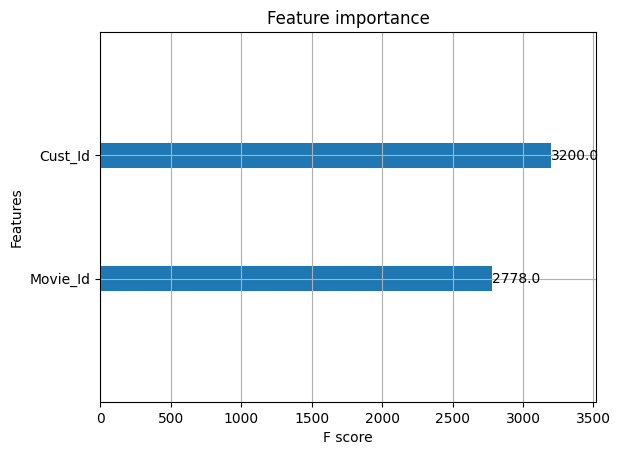

In [32]:
# initialize Our first XGBoost model...
#first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
first_xgb = xgb.XGBRegressor()
train_results, test_results = run_xgboost(first_xgb, dfTrain[['Cust_Id', 'Movie_Id']], dfTrain['Rating'], dfTest[['Cust_Id', 'Movie_Id']], dfTest['Rating'], verbose=True)

# store the results in models_evaluations dictionaries
result = dict()
result['first_algo'] = train_results
result['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()


In [33]:
test_results

{'rmse': 1.1138858509940275,
 'mape': 35.58440577406212,
 'predictions': array([3.546852 , 3.5622885, 3.5075505, ..., 2.6324787, 2.7037997,
        2.7898874], dtype=float32)}